# TS8 MAI - Filtros digitales

<img src="img/parte1.jpg">

<img src="img/res2.jpg">
<img src="img/res1.jpg">

## Simulacion en pyton

In [2]:
import sympy as sp
import numpy as np
from sympy.abc import s
from IPython.display import display, Math

Vi, Vo, VA, VB = sp.symbols("Vi, Vo, VA, VB")
C,R,L1,L3 = sp.symbols("C,R,L1,L3")

Za = sp.Matrix([[s*L1 + 1/(s*C),1/(s*C)],[1/(s*C),s*L3 + 1/(s*C)]])

Zb = sp.Matrix([[R,R],[R,R]])

Ta = sp.Matrix([[Za[0]/Za[2],Za.det()/Za[2]],[1/Za[2],Za[3]/Za[2]]])

Tb = sp.Matrix([[Zb[0]/Zb[2],Zb.det()/Zb[2]],[1/Zb[2],Zb[3]/Zb[2]]])

Tt = Ta.multiply(Tb) #Hago el producto matricial

num, den = sp.fraction(sp.simplify(sp.expand(1/Tt[0])))

num = sp.Poly(num,s)
den = sp.Poly(den,s)

k = sp.simplify(num.LC() / den.LC())

num = num.monic() #hacemos que el numerador y denominador sean monicos
den = den.monic()

den_coeffs = den.all_coeffs()

tf_final = sp.Mul(k,num/den, evaluate=False)

display(tf_final)


(R/(C*L1*L3))/(s**3 + R*s**2/L3 + R/(C*L1*L3) + s*(L1 + L3)/(C*L1*L3))

Su transferencia sera:

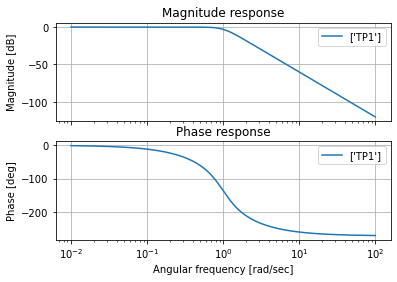

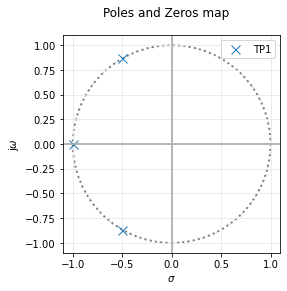

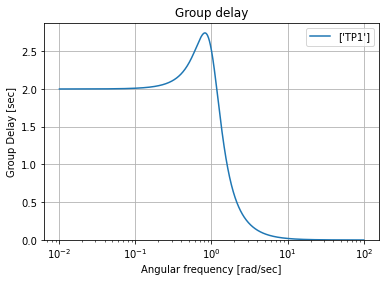

In [3]:
import matplotlib.pyplot as plt
import scipy.signal as sig
from splane import analyze_sys

k= 1

num = np.array([1]) 
den = np.array([1,2,2,1])

tf = sig.TransferFunction(num,den)
    
plt.close('all')
analyze_sys(tf, 'TP1')


Ahora hacemos la verificacion circuital:

<img src="img/simulacion_1.jpg">

Podemos ver que a partir de $\omega = 1$ hay una atenuacion de 60 dB/dec y entonces se verifica la transferencia obtenida.

## Análisis matricial

Ahora se debe construir la MAI y a partir de ella hallar la transferencia:

<img src="img/res3.jpg">

## TP5 ejercicio 2

Se desea emular digitalmente la característica de un filtro analógico pasa bajos Butterworth de
orden 2, con $f_c =1KHz$

Para $f_s =100KHz$ y aplicando transformación bilineal, obtener un filtro con respuesta $H(z)$ cuyo comportamiento emule al Butterworth analógico.
Trazar la respuesta en frecuencia de módulo y fase de ambos filtros sobre un mismo
gráfico para establecer comparaciones.

\begin{equation}
H(s) = \frac{\omega_o^2}{s^2+s\omega_o \sqrt{2}+\omega_o^2}.
\end{equation}

$\omega_o = 2\pi 1KHz$

In [5]:
from sympy import  *
import numpy as np
from sympy.abc import s,z
from IPython.display import display, Math
from splane import pzmap, GroupDelay, bodePlot
from scipy.signal import TransferFunction
import matplotlib.pyplot as plt
from scipy import signal

w_o = 2*pi.evalf(4)*1000

H = w_o**2/(s**2 + s*w_o*sqrt(2).evalf(4) + w_o**2)

display(H)

3.948e+7/(s**2 + 8886.0*s + 3.948e+7)

In [6]:
fs = 1e5
H_z = H.subs(s, (2*fs*(z-1)/(z+1)))
num, den = fraction(simplify(expand(H_z)))  #simplificamos y separamos numerador y denominador

num = Poly(num,z)
den = Poly(den,z)

H_z = num/den

display(simplify(expand(H_z)))

(39478272.0*z**2 + 78956544.0*z + 39478272.0)/(41816628272.0*z**2 - 79921043456.0*z + 38262328272.0)

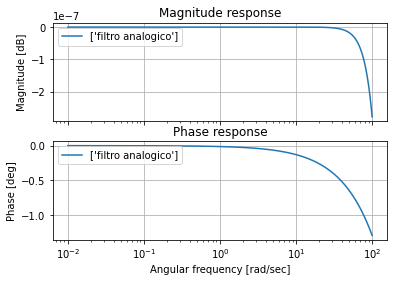

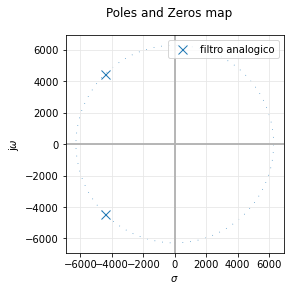

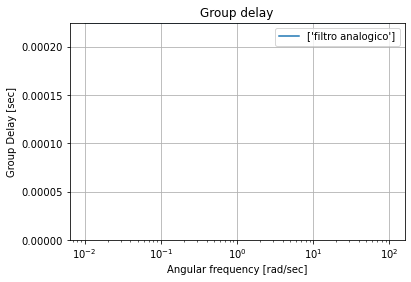

In [8]:
import numpy as np
import math as m
import scipy.signal as sig
import matplotlib as mpl
import matplotlib.pyplot as plt
from splane import analyze_sys, pretty_print_bicuad_omegayq

wo = 2*np.pi*1e3

num_s = [wo**2] #numerador de filtro analogico
den_s = [1,wo*np.sqrt(2),wo**2] #denominador de filtro analogico

tf = sig.TransferFunction(num_s,den_s)
    
plt.close('all')
analyze_sys(tf, 'filtro analogico')

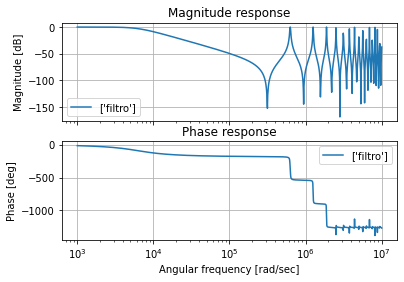

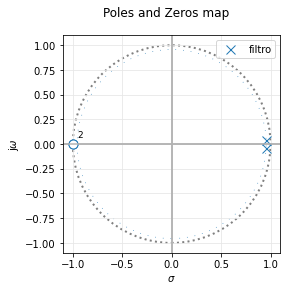

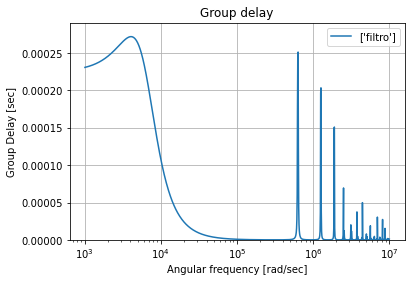

In [9]:
fs = 1e5 #frecuencia de muestreo

num_z,den_z = sig.bilinear(num_s,den_s,fs = fs) #transformo a digital

my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')



Para $f_s = 10KHz$:

In [10]:
fs = 1e4
H_z = H.subs(s, (2*fs*(z-1)/(z+1)))
num, den = fraction(simplify(expand(H_z)))  #simplificamos y separamos numerador y denominador

num = Poly(num,z)
den = Poly(den,z)

H_z = num/den

display(simplify(expand(H_z)))

(39478272.0*z**2 + 78956544.0*z + 39478272.0)/(617193272.0*z**2 - 721043456.0*z + 261763272.0)

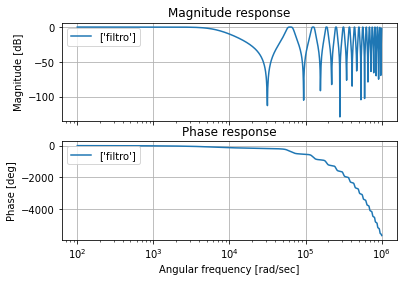

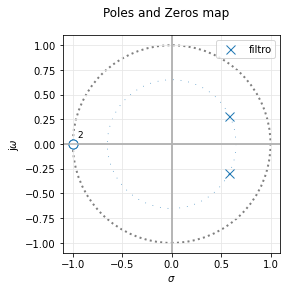

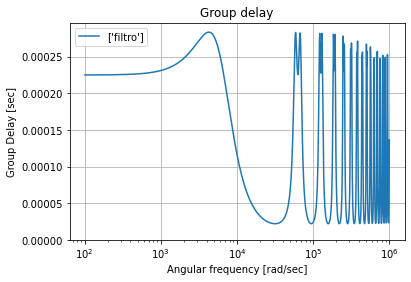

In [11]:
num_z,den_z = sig.bilinear(num_s,den_s,fs = fs) #transformo a digital

my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Si quiero emular un filtro pasa altos Butterworth con $f_c = 6KHz$

\begin{equation}
H(s) = \frac{s^2}{s^2+s\omega_o \sqrt{2}+\omega_o^2}.
\end{equation}

con $\omega_o = 2\pi 6KHz$ y $f_s = 100KHz$

In [14]:
fs = 1e5
w_o = 2*pi.evalf(4)*6000

num_s = [w_o**2] #numerador de filtro analogico
den_s = [1,w_o*np.sqrt(2),w_o**2] #denominador de filtro analogico

H = s**2/(s**2 + s*w_o*sqrt(2).evalf(4) + w_o**2)

display(H)

H_z = H.subs(s, (2*fs*(z-1)/(z+1)))
num, den = fraction(simplify(expand(H_z)))  #simplificamos y separamos numerador y denominador

num = Poly(num,z)
den = Poly(den,z)

H_z = num/den

display(simplify(expand(H_z)))

s**2/(s**2 + 5.331e+4*s + 1.421e+9)

(40000000000.0*z**2 - 80000000000.0*z + 40000000000.0)/(52084113696.0*z**2 - 77157572608.0*z + 30758313696.0)

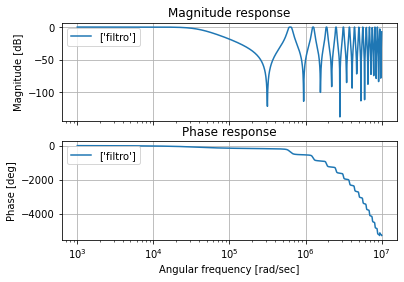

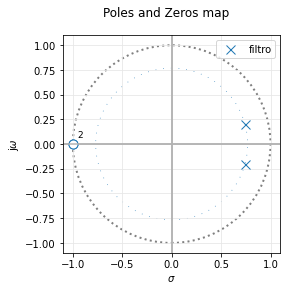

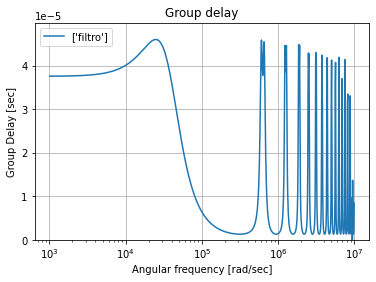

In [15]:
num_z,den_z = sig.bilinear(num_s,den_s,fs = fs) #transformo a digital

my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Ahora con $\omega_o = 2\pi 6KHz$ y $f_s = 10KHz$

(400000000.0*z**2 - 800000000.0*z + 400000000.0)/(2887503696.0*z**2 + 2042427392.0*z + 754923696.0)

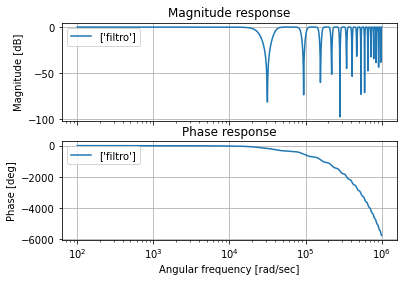

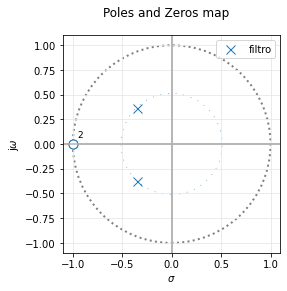

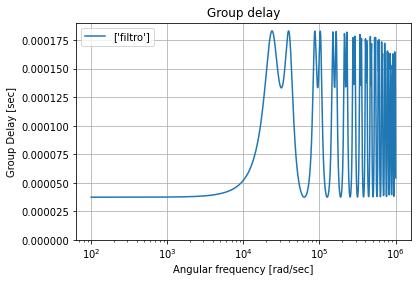

In [16]:
fs = 1e4
w_o = 2*pi.evalf(4)*6000

H_z = H.subs(s, (2*fs*(z-1)/(z+1)))
num, den = fraction(simplify(expand(H_z)))  #simplificamos y separamos numerador y denominador

num = Poly(num,z)
den = Poly(den,z)

H_z = num/den

display(simplify(expand(H_z)))

num_z,den_z = sig.bilinear(num_s,den_s,fs = fs) #transformo a digital

my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Si lo que se busca es tener -3db en $f_c$, se deberia rediseñar aplicando prewarping en los 3 casos.

## TP5 ejercicio 3

Filtro de media movil

$h_1(k) = (1,1)$

Esto se traduce en:

$H(z)=1+1.z^{-1} = \frac{1+z}{z}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

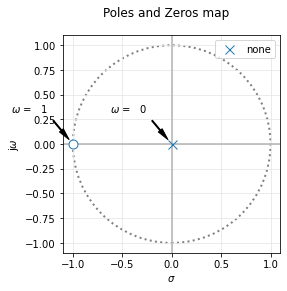

In [17]:
from splane import pzmap, GroupDelay, bodePlot
from scipy.signal import TransferFunction
import matplotlib.pyplot as plt

num_z = [1,1] #numerador de filtro digital
den_z = [1,0] #denominador de filtro digital

my_tf = TransferFunction( num_z, den_z )
pzmap(my_tf, 2) #S plane pole/zero plot


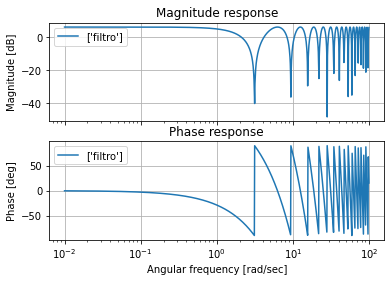

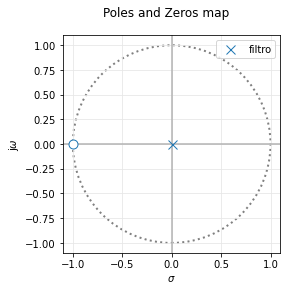

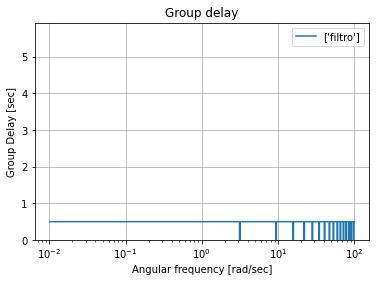

In [14]:
fs = 1
my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

$h_2(k) = (1,1,1)$

Esto se traduce en:

$H(z)=1+1.z^{-1}+1.z^{-2} = \frac{1+z+z^2}{z^2}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

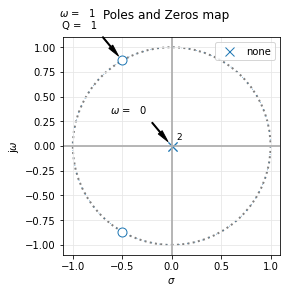

In [18]:
num_z = [1,1,1] #numerador de filtro digital
den_z = [1,0,0] #denominador de filtro digital

my_tf = TransferFunction( num_z, den_z )
pzmap(my_tf, 2) #S plane pole/zero plot

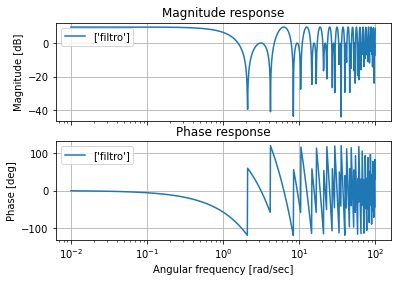

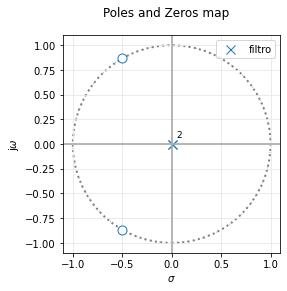

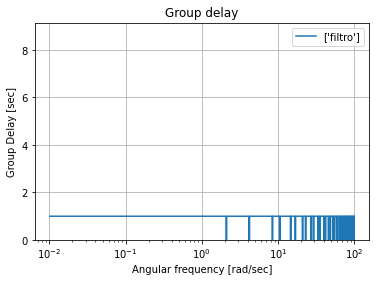

In [19]:
fs = 1
my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Para que la salida represente la media aritmetica deberia ser dividida por la cantidad de muestras.

Si en el ultimo sistema se busca eliminar la frecuencia f=50Hz se debe hallar el $\Omega$ en donde se produce ese cero:

In [20]:
root = np.roots(num_z)
print("angulo =",(np.angle(root[0]))*360/(2*pi.evalf(4)))

angulo = 119.999961453320


$ \Omega = \frac{2\pi f}{f_s}$ 

$f_s = 151Hz$

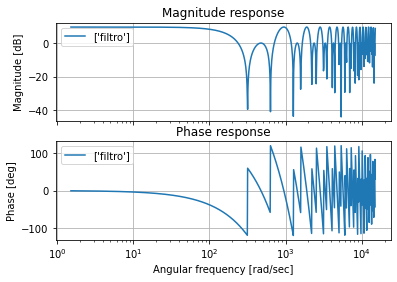

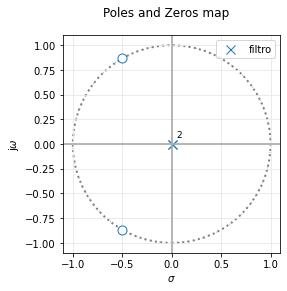

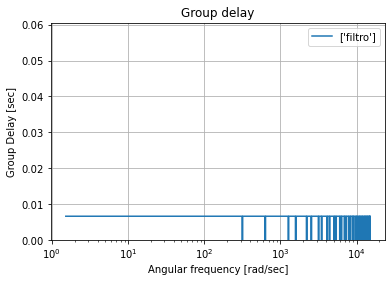

In [21]:
fs = 151
my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Filtro diferenciador

$h_1(k) = (1,-1)$

Esto se traduce en:

$H(z)=1-z^{-1} = \frac{z-1}{z}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

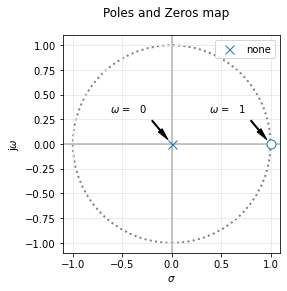

In [38]:
num_z = [1,-1] #numerador de filtro digital
den_z = [1,0] #denominador de filtro digital

my_tf = TransferFunction( num_z, den_z )
pzmap(my_tf, 2) #S plane pole/zero plot

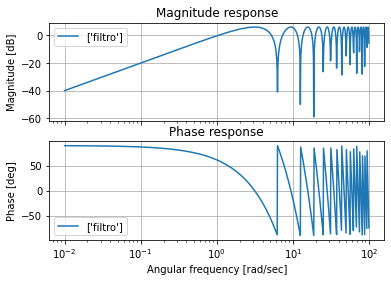

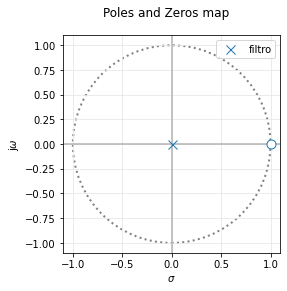

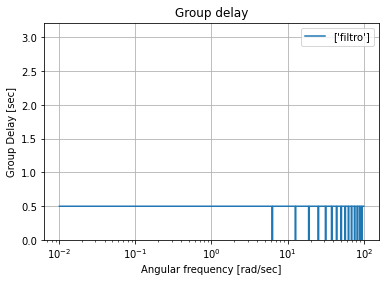

In [39]:
fs = 1
my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Este sistema tiene una demora de 0.5s

$h_2(k) = (1,0,-1)$

Esto se traduce en:

$H(z)=1-z^{-2} = \frac{z^2 -1}{z^2}$

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

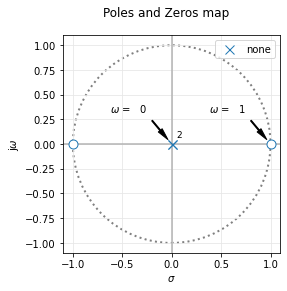

In [36]:
num_z = [1,0,-1] #numerador de filtro digital
den_z = [1,0,0] #denominador de filtro digital

my_tf = TransferFunction( num_z, den_z )
pzmap(my_tf, 2) #S plane pole/zero plot

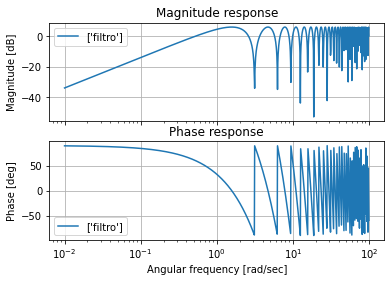

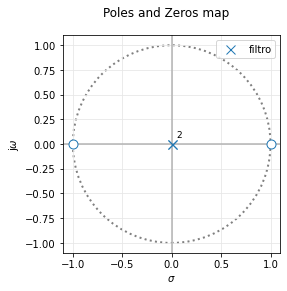

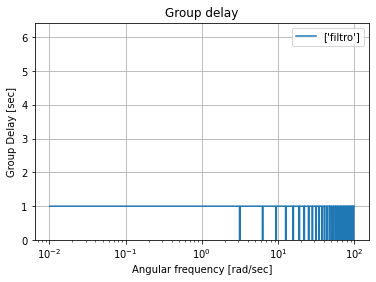

In [37]:
fs = 1
my_dig_filter = sig.TransferFunction(num_z,den_z,dt = 1/fs) #al indicar dt le decimos a la funcion que la transferencia es en Z
analyze_sys(my_dig_filter,'filtro')

Este sistema tiene una demora de 1s